In [5]:
import os
import h5py
import numpy as np

# Function to calculate detector shifts
def calculate_detector_shifts(center_x, center_y):
    pixels_per_meter = 17857.14285714286
    presumed_center = 512
    det_shift_x_mm = -((center_x - presumed_center) / pixels_per_meter) * 1000
    det_shift_y_mm = -((center_y - presumed_center) / pixels_per_meter) * 1000
    return det_shift_x_mm, det_shift_y_mm

# Main function to process each .h5 file in the directory
def process_h5_files(folder_path, output_h5_file):
    all_relative_peak_x = []
    all_relative_peak_y = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.h5'):
            hdf5_path = os.path.join(folder_path, filename)
            
            # Read existing data and calculate detector shifts
            with h5py.File(hdf5_path, 'r') as h5file:
                center_x = h5file['entry/data/center_x'][:]
                center_y = h5file['entry/data/center_y'][:]
                peakXPosRaw = h5file['entry/data/peakXPosRaw'][:]
                peakYPosRaw = h5file['entry/data/peakYPosRaw'][:]

            det_shift_x_mm, det_shift_y_mm = calculate_detector_shifts(center_x, center_y)
            
            # Update det_shift in the original .h5 files
            with h5py.File(hdf5_path, 'a') as h5file:
                for ds_name in ['entry/data/det_shift_x_mm', 'entry/data/det_shift_y_mm']:
                    if ds_name in h5file:
                        del h5file[ds_name]
                h5file.create_dataset('entry/data/det_shift_x_mm', data=det_shift_x_mm, maxshape=(None,), dtype='float64')
                h5file.create_dataset('entry/data/det_shift_y_mm', data=det_shift_y_mm, maxshape=(None,), dtype='float64')

            # Calculate relative peak positions
            for idx, (cx, cy) in enumerate(zip(center_x, center_y)):
                relative_peak_x = peakXPosRaw[idx] - cx
                relative_peak_y = peakYPosRaw[idx] - cy
                all_relative_peak_x.append(relative_peak_x)
                all_relative_peak_y.append(relative_peak_y)

    # Save all the relative peak positions into a new HDF5 file
    with h5py.File(output_h5_file, 'w') as h5file:
        h5file.create_dataset('all_relative_peak_x', data=np.array(all_relative_peak_x), dtype='float64')
        h5file.create_dataset('all_relative_peak_y', data=np.array(all_relative_peak_y), dtype='float64')

# Specify the folder containing the .h5 files
folder_path = "/home/buster/leidata/hMTH1_TH287_Serial/45deg"
output_h5_file = "/home/buster/leidata/hMTH1_TH287_Serial/45deg/relative_shifts_file.h5"

# Process all .h5 files in the folder and save to a new .h5 file
process_h5_files(folder_path, output_h5_file)


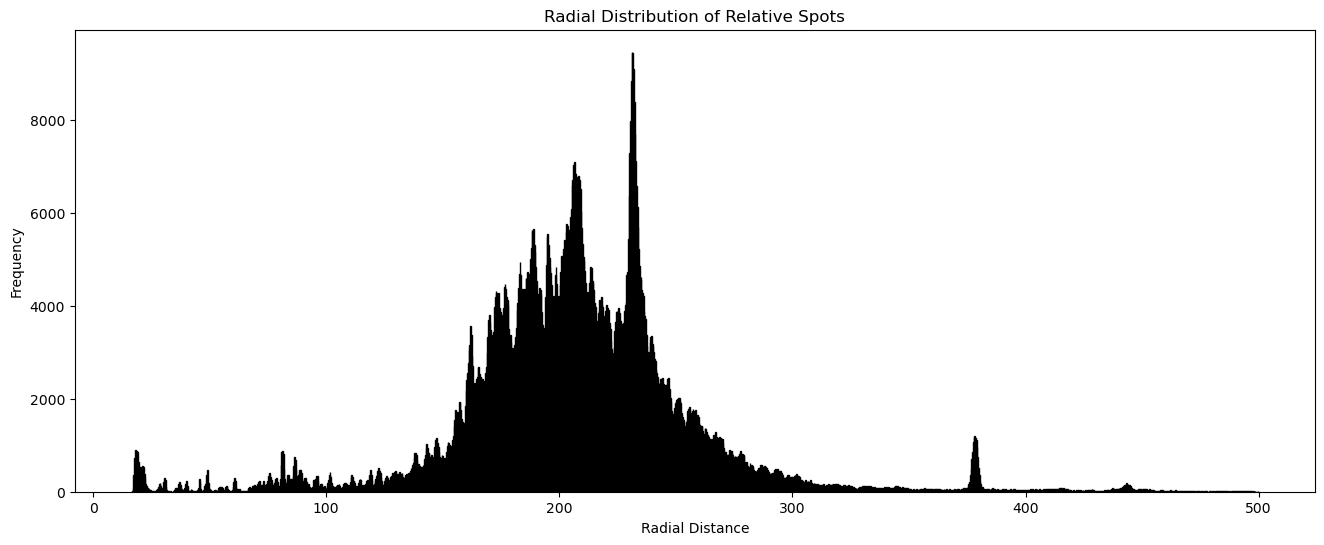

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def read_relative_peak_positions(h5_file_path):
    with h5py.File(h5_file_path, 'r') as h5file:
        all_relative_peak_x = h5file['all_relative_peak_x'][:]
        all_relative_peak_y = h5file['all_relative_peak_y'][:]
    return all_relative_peak_x, all_relative_peak_y

def calculate_radial_distances(x, y):
    return np.sqrt(x**2 + y**2)

def filter_radial_distances(radial_distances, min_distance, max_distance):
    return radial_distances[(radial_distances >= min_distance) & (radial_distances <= max_distance)]

def plot_radial_distribution(radial_distances, num_bins=1500):
    plt.figure(figsize=(16, 6))
    plt.hist(radial_distances, bins=num_bins, edgecolor='black')
    plt.title('Radial Distribution of Relative Spots')
    plt.xlabel('Radial Distance')
    plt.ylabel('Frequency')
    plt.show()

if __name__ == "__main__":

    h5_file_path = "/home/buster/leidata/hMTH1_TH287_Serial/45deg/relative_shifts_file.h5"  # Replace with your actual file path
    min_distance = 10  # Replace with your minimum distance

    max_distance = 500  # Replace with your maximum distance
    
    # Read the relative peak positions from the HDF5 file
    all_relative_peak_x, all_relative_peak_y = read_relative_peak_positions(h5_file_path)
    
    # Flatten the 2D arrays to 1D arrays
    all_relative_peak_x = all_relative_peak_x.flatten()
    all_relative_peak_y = all_relative_peak_y.flatten()
    
    # Calculate the radial distances
    radial_distances = calculate_radial_distances(all_relative_peak_x, all_relative_peak_y)
    
    # Filter the radial distances based on the specified range
    filtered_radial_distances = filter_radial_distances(radial_distances, min_distance, max_distance)
    
    # Plot the radial distribution
    plot_radial_distribution(filtered_radial_distances)
